In [1]:
pip uninstall opencv-python -y

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python39\\Scripts\\tqdm.exe' -> 'C:\\Python39\\Scripts\\tqdm.exe.deleteme'

You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
import pickle
warnings.filterwarnings('ignore')


In [2]:
model_path = 'RCNN_crop_weed_classification_model.h5'
test_img_path = 'Test/'
images_path = 'agri_data/data/'
svm_model_path = 'svm_classifier.pkl'
images_name = [x for x in os.listdir(images_path) if x.endswith('.jpeg')]

In [6]:
model = tf.keras.models.load_model(model_path)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
model_without_last_two_fc = tf.keras.models.Model(model.inputs,model.layers[-5].output)

In [9]:
model_without_last_two_fc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
with open(svm_model_path,'rb') as svm:
    svm_model = pickle.load(svm)

## Defining function for iou calculation

In [3]:
def iou_calc(bb1 , bb2):
  
    true_xmin, true_ymin, true_width, true_height  = bb1
    bb_xmin, bb_ymin,  bb_width, bb_height = bb2

    true_xmax = true_xmin + true_width
    true_ymax = true_ymin + true_height
    bb_xmax = bb_xmin + bb_width
    bb_ymax = bb_ymin + bb_height

    #calculating area
    true_area = true_width * true_height
    bb_area   = bb_width * bb_height 

    #calculating itersection cordinates
    inter_xmin = max(true_xmin , bb_xmin) 
    inter_ymin = max(true_ymin , bb_ymin)
    inter_xmax = min(true_xmax , bb_xmax)
    inter_ymax = min(true_ymax , bb_ymax)

    if inter_xmax <= inter_xmin or inter_ymax <= inter_ymin:
        iou = 0


    else:
        inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)


        iou = inter_area / (true_area + bb_area - inter_area)
        
    assert iou<=1
    assert iou>=0
    
    return iou

# Performing detection

In [4]:
def detection(img_path,confidence=0.9,iou_thresh=0.1):
    
    # appling selective search
    img = plt.imread(img_path)
    cv2.setUseOptimized(True)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    sel_rects = rects[:100]
    
    pred_crop=[]
    pred_weed=[]
    for index, rect in tqdm(enumerate(sel_rects)):

        x,y,w,h = rect
        roi = img[y:y+h,x:x+w,:]
        resized_roi = cv2.resize(roi,(224,224))/255
        
        # Feature extraction
        
        feature = model_without_last_two_fc.predict(resized_roi.reshape(-1,224,224,3))
        
        # SVM prediction
        pred = svm_model.predict_proba(feature.reshape(-1,4096))
        pred_lab=svm_model.predict(feature.reshape(-1,4096))

        if pred_lab == 'crop' and np.max(pred)>confidence:
            pred_crop.append([list(rect),np.max(pred)])
        elif pred_lab=='weed' and np.max(pred)>confidence:
            pred_weed.append([list(rect),np.max(pred)])
            
    final = []
    
    # Detection for crop class
    if len(pred_crop) != 0:
        pred_score_crop = [x[1] for x in pred_crop]
        pred_bb_crop = [x[0] for x in pred_crop]

        for i in range(len(pred_crop)):
            temp_bb , temp_score = pred_bb_crop.copy() , pred_score_crop.copy()
            if len(temp_bb) !=0:

                max_score_box = temp_bb[np.argmax(temp_score)]

                if [max_score_box,np.max(temp_score)] not in final:
                    final.append([max_score_box,np.max(temp_score),'crop'])
                    index_should_del = []

                    for ind,other_bb in enumerate(temp_bb):
                        iou_score = iou_calc(max_score_box , other_bb)
                        
                        # Non maximum suppression(nms)
                        
                        if iou_score >= iou_thresh:
                            index_should_del.append(ind)

                    pred_bb_crop    = []
                    pred_score_crop = []
                    for bb_index ,bb_value in enumerate(temp_bb) :
                        if bb_index not in index_should_del:
                            pred_bb_crop.append(bb_value)

                    for score_index ,score_value in enumerate(temp_score) :
                        if score_index not in index_should_del:
                            pred_score_crop.append(score_value)
                else:
                    continue

            else:
                break

    # Detection for weed class

    if len(pred_weed) != 0:
        pred_score_weed = [x[1] for x in pred_weed]
        pred_bb_weed = [x[0] for x in pred_weed]

        for i in range(len(pred_weed)):
            temp_bb , temp_score = pred_bb_weed.copy() , pred_score_weed.copy()
            if len(temp_bb) !=0:

                max_score_box = temp_bb[np.argmax(temp_score)]

                if [max_score_box,np.max(temp_score)] not in final:
                    final.append([max_score_box,np.max(temp_score),'weed'])
                    index_should_del = []

                    for ind,other_bb in enumerate(temp_bb):
                        iou_score = iou_calc(max_score_box , other_bb)

                        if iou_score >= iou_thresh:
                            index_should_del.append(ind)

                    pred_bb_weed    = []
                    pred_score_weed = []
                    for bb_index ,bb_value in enumerate(temp_bb) :
                        if bb_index not in index_should_del:
                            pred_bb_weed.append(bb_value)

                    for score_index ,score_value in enumerate(temp_score) :
                        if score_index not in index_should_del:
                            pred_score_weed.append(score_value)
                else:
                    continue

            else:
                break
    
   
    imOut = img.copy()
    for rect,score,cls in final:
        
        x,y,w,h = rect
        if cls == 'weed':
            color =(255,0,0)
        if cls == 'crop':
            color = (0,255,0)

        cv2.rectangle(imOut,(x,y),(x+w,y+h),color,2)

        cv2.putText(imOut,cls+':'+str(round(score*100,2)),(x,y-8),cv2.FONT_HERSHEY_SIMPLEX,1, color, 2, cv2.LINE_AA)
    plt.imshow(imOut)
    cv2.imwrite('prediction.jpeg',imOut)
   

    return final 

1it [00:09,  9.79s/it]


[]

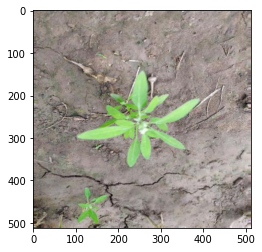

In [11]:
detection('agri_data/data/agri_0_352.jpeg')

1it [00:00,  2.33it/s]


[]

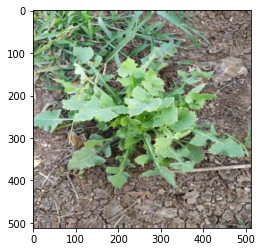

In [12]:
detection(images_path+images_name[1245])

1832it [12:03,  2.53it/s]


[[[0, 0, 114, 216], 0.9975751333059065, 'crop'],
 [[193, 59, 159, 183], 0.9968649419492699, 'crop'],
 [[174, 207, 234, 231], 0.9597226907805718, 'crop']]

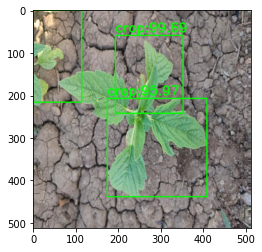

In [14]:
detection(images_path+images_name[100])